In [1]:
#-------Importing Packages-----#
import pyranges as pr
import warnings
import numpy as np
import pandas as pd
import anndata as ad
import scanpy as sc
import pandas as pd 
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import SEACells
import os
from scipy.io import mmread #Reading in mtx file 
from scipy.sparse import csr_matrix #convert from coo to csr matrix

In [2]:
#-------Setting up Plot Aesthetics-----#
%matplotlib inline
sns.set_style('ticks')
matplotlib.rcParams['figure.figsize'] = [3, 3]
matplotlib.rcParams['figure.dpi'] = 300

In [3]:
#------Loading in Data from archR------#
print("Loading in Data")
ConversionDirectory =  "/projects/b1217/HHA/Multiome_Scanpy_Conversion/Full_Atlas/"
#Reading in the raw count matrix from seurat.combined
counts = mmread(os.path.join(ConversionDirectory, "HHA_Matrix_Multiome_ATAC_Metadata_PeakMatrix_5_30_25.mtx"))
counts = csr_matrix(counts.transpose()) #transposing to cell x gene matrix and converting to csr format
#Contains metadata, barcodes, and umap embeddings 
metadata = pd.read_csv(os.path.join(ConversionDirectory, "HHA_Matrix_Multiome_ATAC_Metadata_5_30_25.csv"))
#Contains peak granges info 
#Contains peak granges info 
peaks = pd.read_csv(os.path.join(ConversionDirectory, "HHA_Matrix_Multiome_ATAC_Metadata_PeakMatrix_RegionNames_5_30_25.csv"))
peaks.index = peaks['seqnames'] + ':' + peaks['start'].astype(str) + '-' + peaks['end'].astype(str)

#----Converting to anndata object------#
print("Building Object")
Matrix = ad.AnnData(counts) #creating anndata object
Matrix.obs_names = metadata["UnifiedBarcode"] #Adding barcodes as obs names 
Matrix.var_names = peaks.index #adding gene names 
#Adding peak metadata
for col in peaks.columns:
  Matrix.var[col] = peaks[col]
print(Matrix)
print(Matrix.obs_names[:10])
print(Matrix.var_names[:10])
harmony = pd.read_csv(os.path.join(ConversionDirectory, "HHA_Matrix_Multiome_ATAC_Harmony_5_30_25.csv"))
harmony["barcode"] = metadata["UnifiedBarcode"]
#------Adding metadata to anndata--------#
Matrix.obs = metadata
Matrix.obs_names = metadata["UnifiedBarcode"]

#-----Adding dimensionality reductions to obsm-----#
print("Adding Gene Scores")
X_umap_atac = metadata.set_index("UnifiedBarcode")[["ATAC_UMAP1", "ATAC_UMAP2"]]
X_umap_wnn = metadata.set_index("UnifiedBarcode")[["WNN_UMAP1", "WNN_UMAP2"]]
Matrix.obsm['X_umap_atac'] = X_umap_atac.loc[Matrix.obs_names].values
Matrix.obsm['X_umap_wnn'] = X_umap_wnn.loc[Matrix.obs_names].values
X_harmony = harmony.set_index("barcode")
Matrix.obsm['X_harmony'] = X_harmony.loc[Matrix.obs_names].values
print(Matrix.obs.head())

Loading in Data
Building Object
AnnData object with n_obs × n_vars = 7728 × 503457
    var: 'seqnames', 'start', 'end', 'width', 'strand', 'score', 'replicateScoreQuantile', 'groupScoreQuantile', 'Reproducibility', 'GroupReplicate', 'distToGeneStart', 'nearestGene', 'peakType', 'distToTSS', 'nearestTSS', 'GC', 'idx', 'N'
Index(['EL_C6_ACAACAGAGGTTACAC-1', 'EL_C6_GCAGCCAGTGGGTGAA-1',
       'EL_C6_TGGCCAATCTTAGGGT-1', 'EL_C6_GCTATTGCAATATGGA-1',
       'EL_C6_CGGACAACAACAGGAT-1', 'EL_C6_ATGGCCCAGGTGCGGA-1',
       'EL_C6_GCATATATCAATTACG-1', 'EL_C6_TAATTGCCATAAACCT-1',
       'EL_C6_GCATTAGGTACTGAAT-1', 'EL_C6_ATGTTGTCATGCTTAG-1'],
      dtype='object', name='UnifiedBarcode')
Index(['chr1:794881-795381', 'chr1:807664-808164', 'chr1:812077-812577',
       'chr1:817096-817596', 'chr1:817866-818366', 'chr1:818524-819024',
       'chr1:819735-820235', 'chr1:823124-823624', 'chr1:826685-827185',
       'chr1:827276-827776'],
      dtype='object')
Adding Gene Scores
                          

/projects/b1217/Chris/condaenvs/SEACellsEnv/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


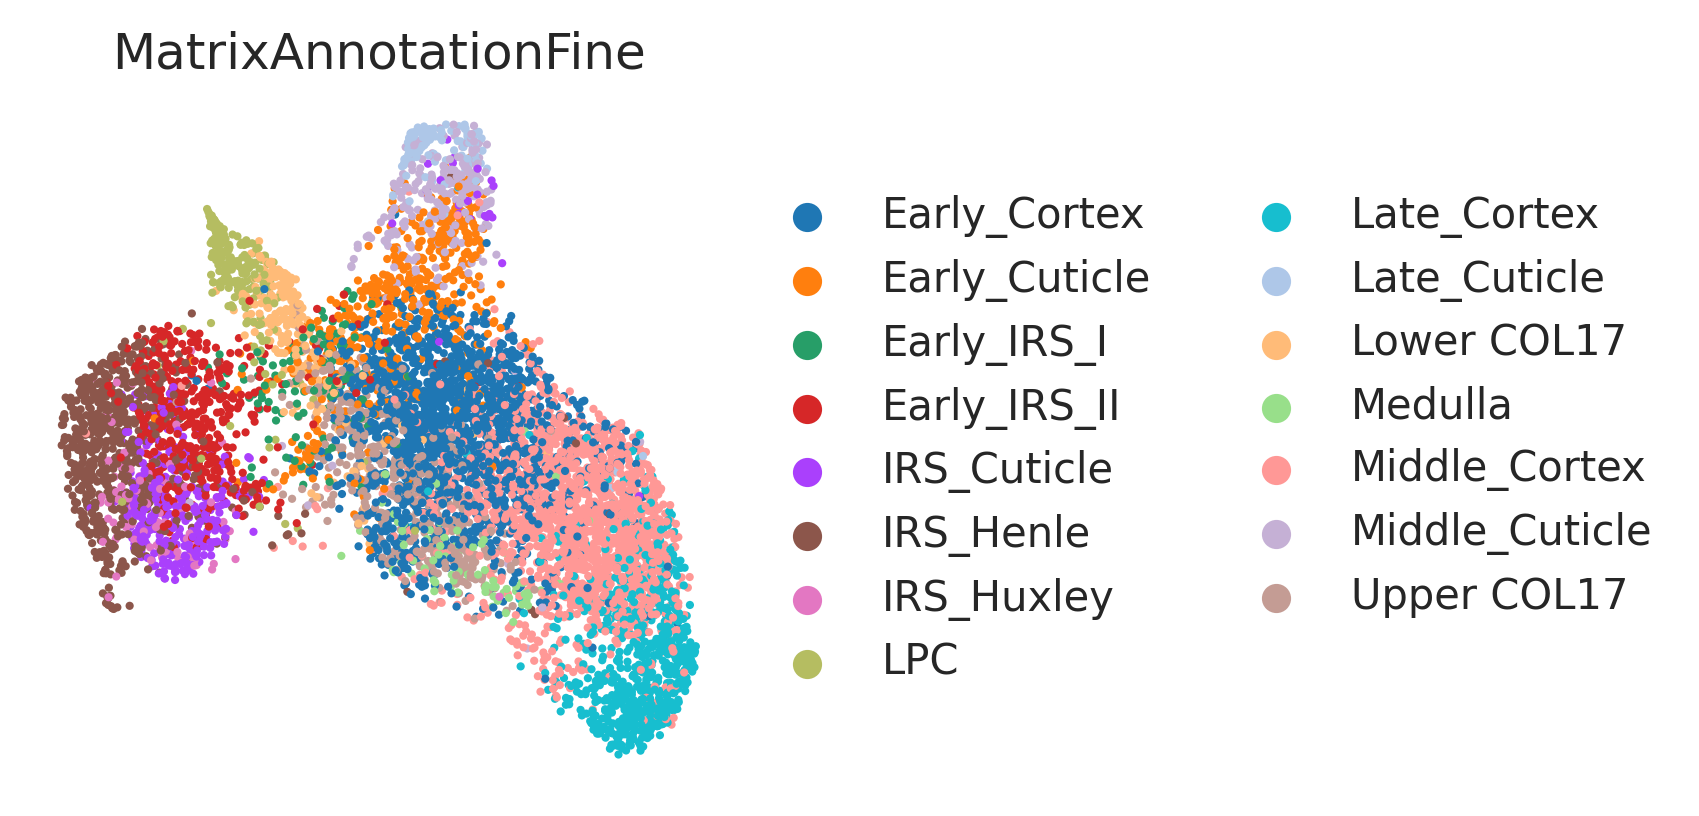

/projects/b1217/Chris/condaenvs/SEACellsEnv/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


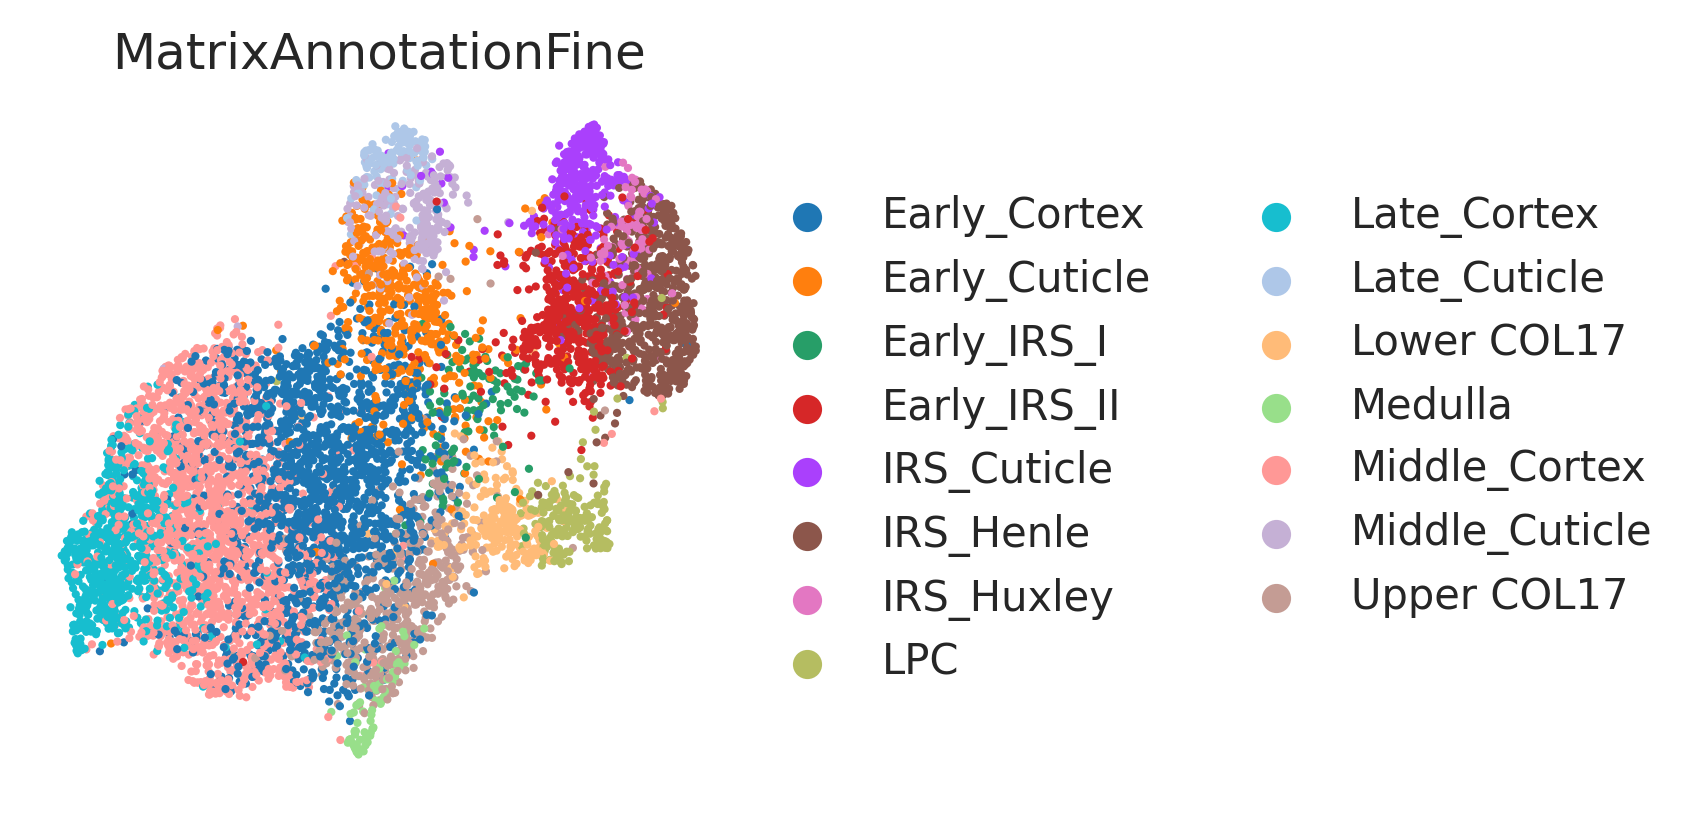

In [6]:
#------Plotting Embeddings------#
#Plotting ATAC UMAP
sc.pl.embedding(Matrix, color="MatrixAnnotationFine", basis = "X_umap_atac",
                    frameon=False)
#Plotting WNN UMAP
sc.pl.embedding(Matrix, color="MatrixAnnotationFine", basis = "X_umap_wnn",
                    frameon=False)

In [7]:
# Copy the counts to ".raw" attribute of the anndata since it is necessary for downstream analysis
raw_ad = sc.AnnData(Matrix.X)
raw_ad.obs_names, raw_ad.var_names = Matrix.obs_names, Matrix.var_names
Matrix.raw = raw_ad

In [8]:
#-------Running SEACells-----#
## User defined parameters
# Core parameters 
n_SEACells = 103 #75 cells per metacell
build_kernel_on = 'X_harmony' #trying out scvi latent representation
# Additional parameters
n_waypoint_eigs = 10 # Number of diffmap eigenvalues to consider when initializing metacells
#Initializing model
model = SEACells.core.SEACells(Matrix, 
                  build_kernel_on=build_kernel_on, 
                  n_SEACells=n_SEACells, 
                  n_waypoint_eigs=n_waypoint_eigs,
                  convergence_epsilon = 1e-5)

Welcome to SEACells!


In [9]:
#-------Building Kernel Matrix-----#
model.construct_kernel_matrix()
M = model.kernel_matrix

Computing kNN graph using scanpy NN ...
Computing radius for adaptive bandwidth kernel...


  0%|          | 0/7728 [00:00<?, ?it/s]

Making graph symmetric...
Parameter graph_construction = union being used to build KNN graph...
Computing RBF kernel...


  0%|          | 0/7728 [00:00<?, ?it/s]

Building similarity LIL matrix...


  0%|          | 0/7728 [00:00<?, ?it/s]

Constructing CSR matrix...


/projects/b1217/Chris/condaenvs/SEACellsEnv/lib/python3.8/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/projects/b1217/Chris/condaenvs/SEACellsEnv/lib/python3.8/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


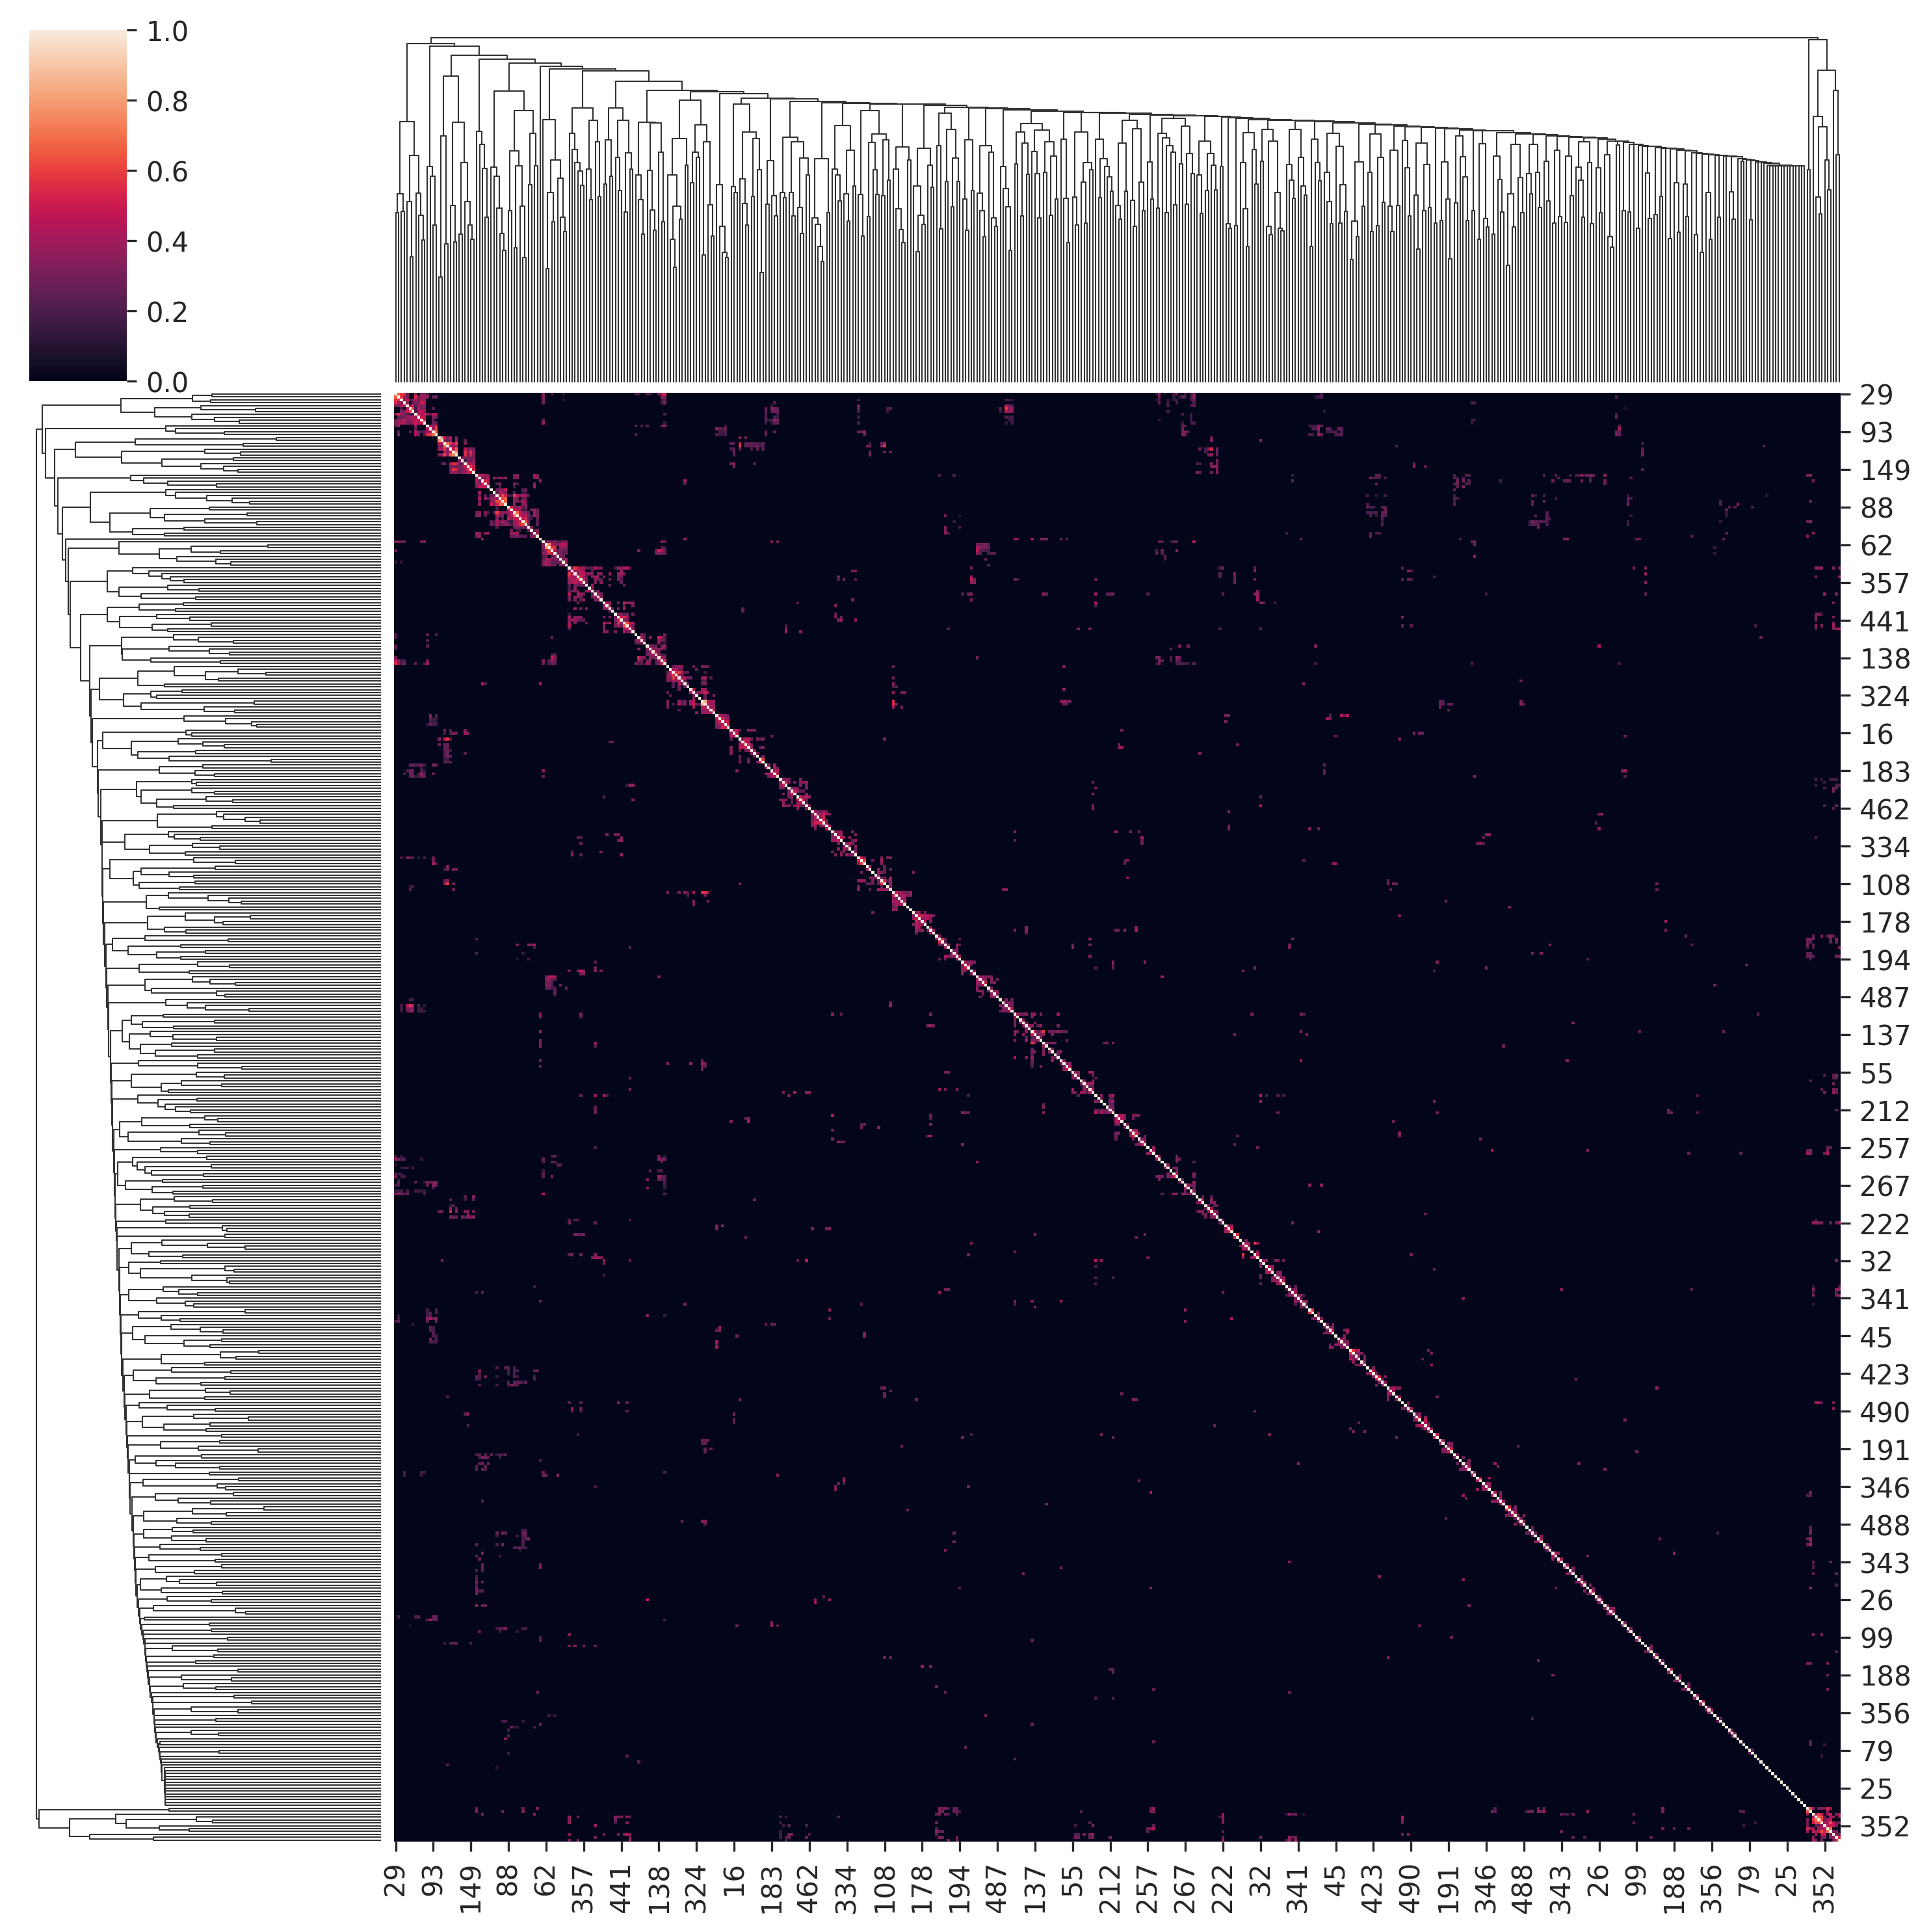

In [10]:
#----------Plotting matrix for first 500 cells-----#
sns.clustermap(M.toarray()[:500,:500])

In [11]:
#------Finding metacells-----#
# Initializing archetypes
model.initialize_archetypes()

Building kernel on X_harmony
Computing diffusion components from X_harmony for waypoint initialization ... 
Done.
Sampling waypoints ...
Done.
Selecting 95 cells from waypoint initialization.
Initializing residual matrix using greedy column selection
Initializing f and g...


100%|██████████| 18/18 [00:00<00:00, 106.68it/s]

Selecting 8 cells from greedy initialization.


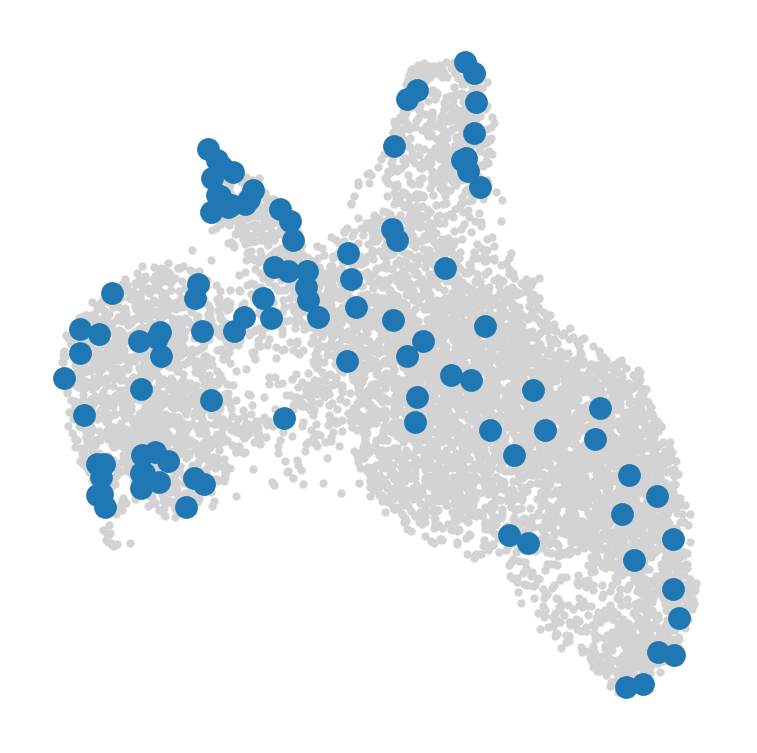

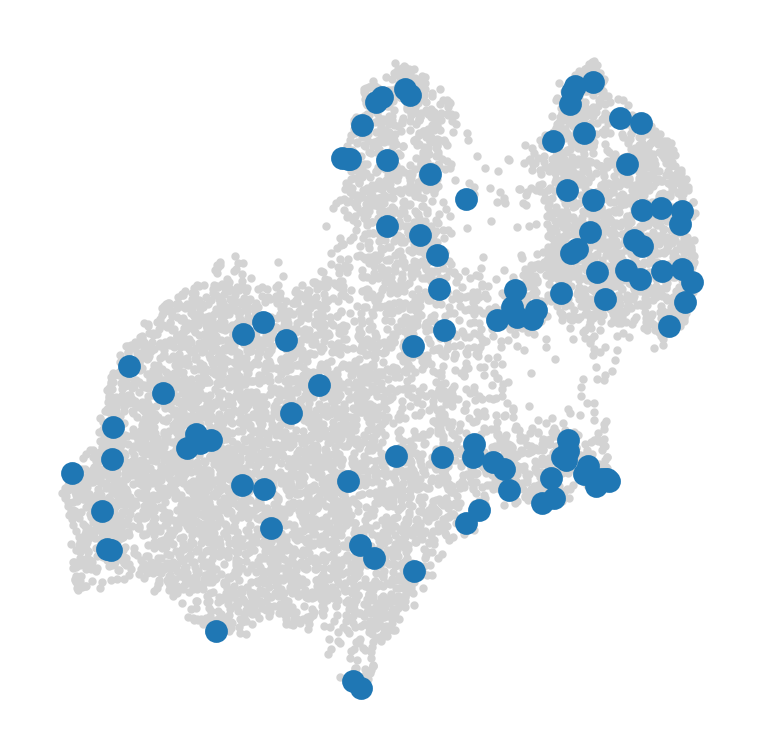

In [12]:
# Plot the initilization to ensure they are spread across phenotypic space
SEACells.plot.plot_initialization(Matrix, model, plot_basis = "X_umap_atac")
SEACells.plot.plot_initialization(Matrix, model, plot_basis = "X_umap_wnn")

In [13]:
#-----Fitting model-----#
model.fit(min_iter=10, max_iter=50)

Randomly initialized A matrix.
Setting convergence threshold at 0.00157
Starting iteration 1.
Completed iteration 1.
Starting iteration 10.
Completed iteration 10.
Starting iteration 20.
Completed iteration 20.
Starting iteration 30.
Completed iteration 30.
Converged after 35 iterations.


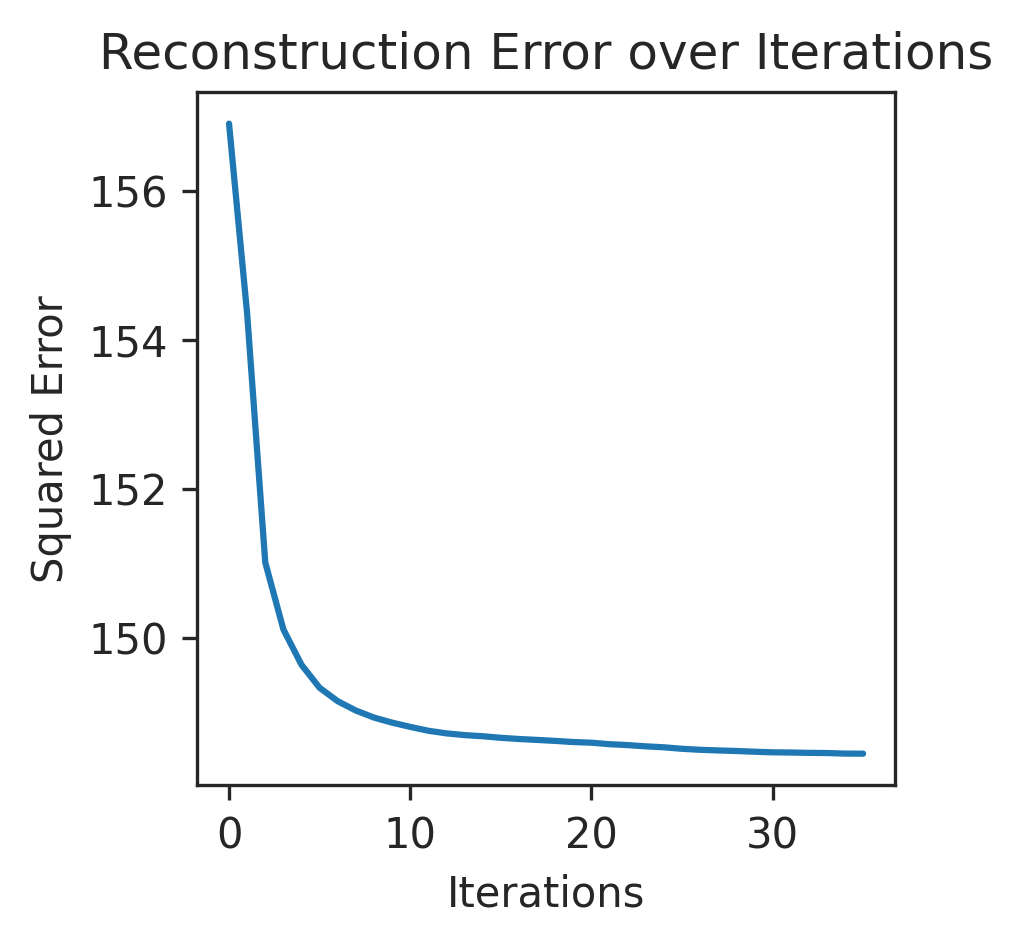

In [14]:
#------Checking for convergence-----#
model.plot_convergence() #convergence looks good

<ipython-input-15-ece6d8c7c79e>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot((model.A_.T > 0.1).sum(axis=1), kde=False)


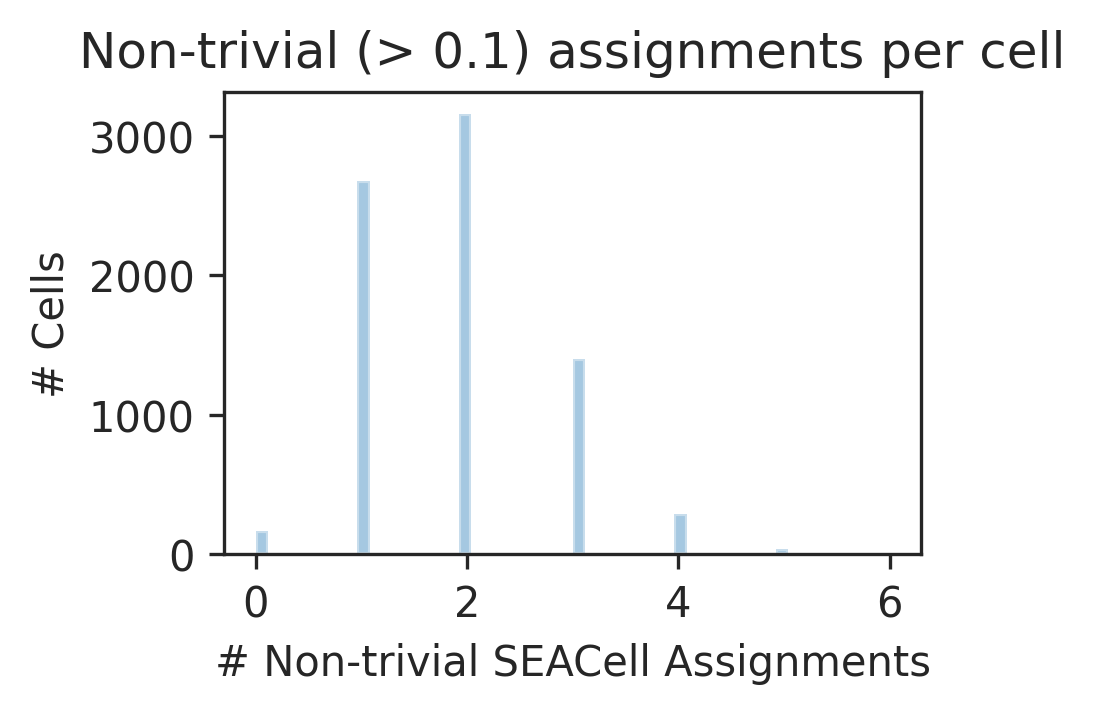

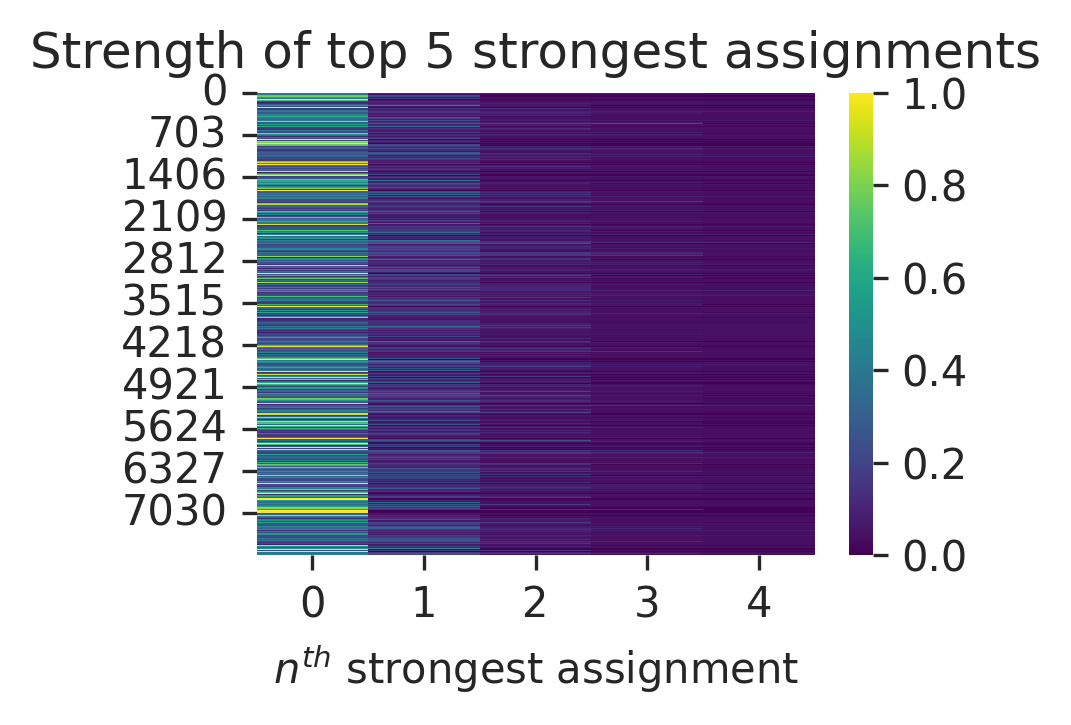

In [15]:
#-----Plotting soft assignments-----#
#histogram
plt.figure(figsize=(3,2))
sns.distplot((model.A_.T > 0.1).sum(axis=1), kde=False)
plt.title(f'Non-trivial (> 0.1) assignments per cell')
plt.xlabel('# Non-trivial SEACell Assignments')
plt.ylabel('# Cells')
plt.show()
#heatmap
plt.figure(figsize=(3,2))
b = np.partition(model.A_.T, -5)    
sns.heatmap(np.sort(b[:,-5:])[:, ::-1], cmap='viridis', vmin=0)
plt.title('Strength of top 5 strongest assignments')
plt.xlabel('$n^{th}$ strongest assignment')
plt.show()

/projects/b1217/Chris/condaenvs/SEACellsEnv/lib/python3.8/site-packages/SEACells/plot.py:121: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(label_df.groupby('SEACell').count().iloc[:, 0], bins=bins)


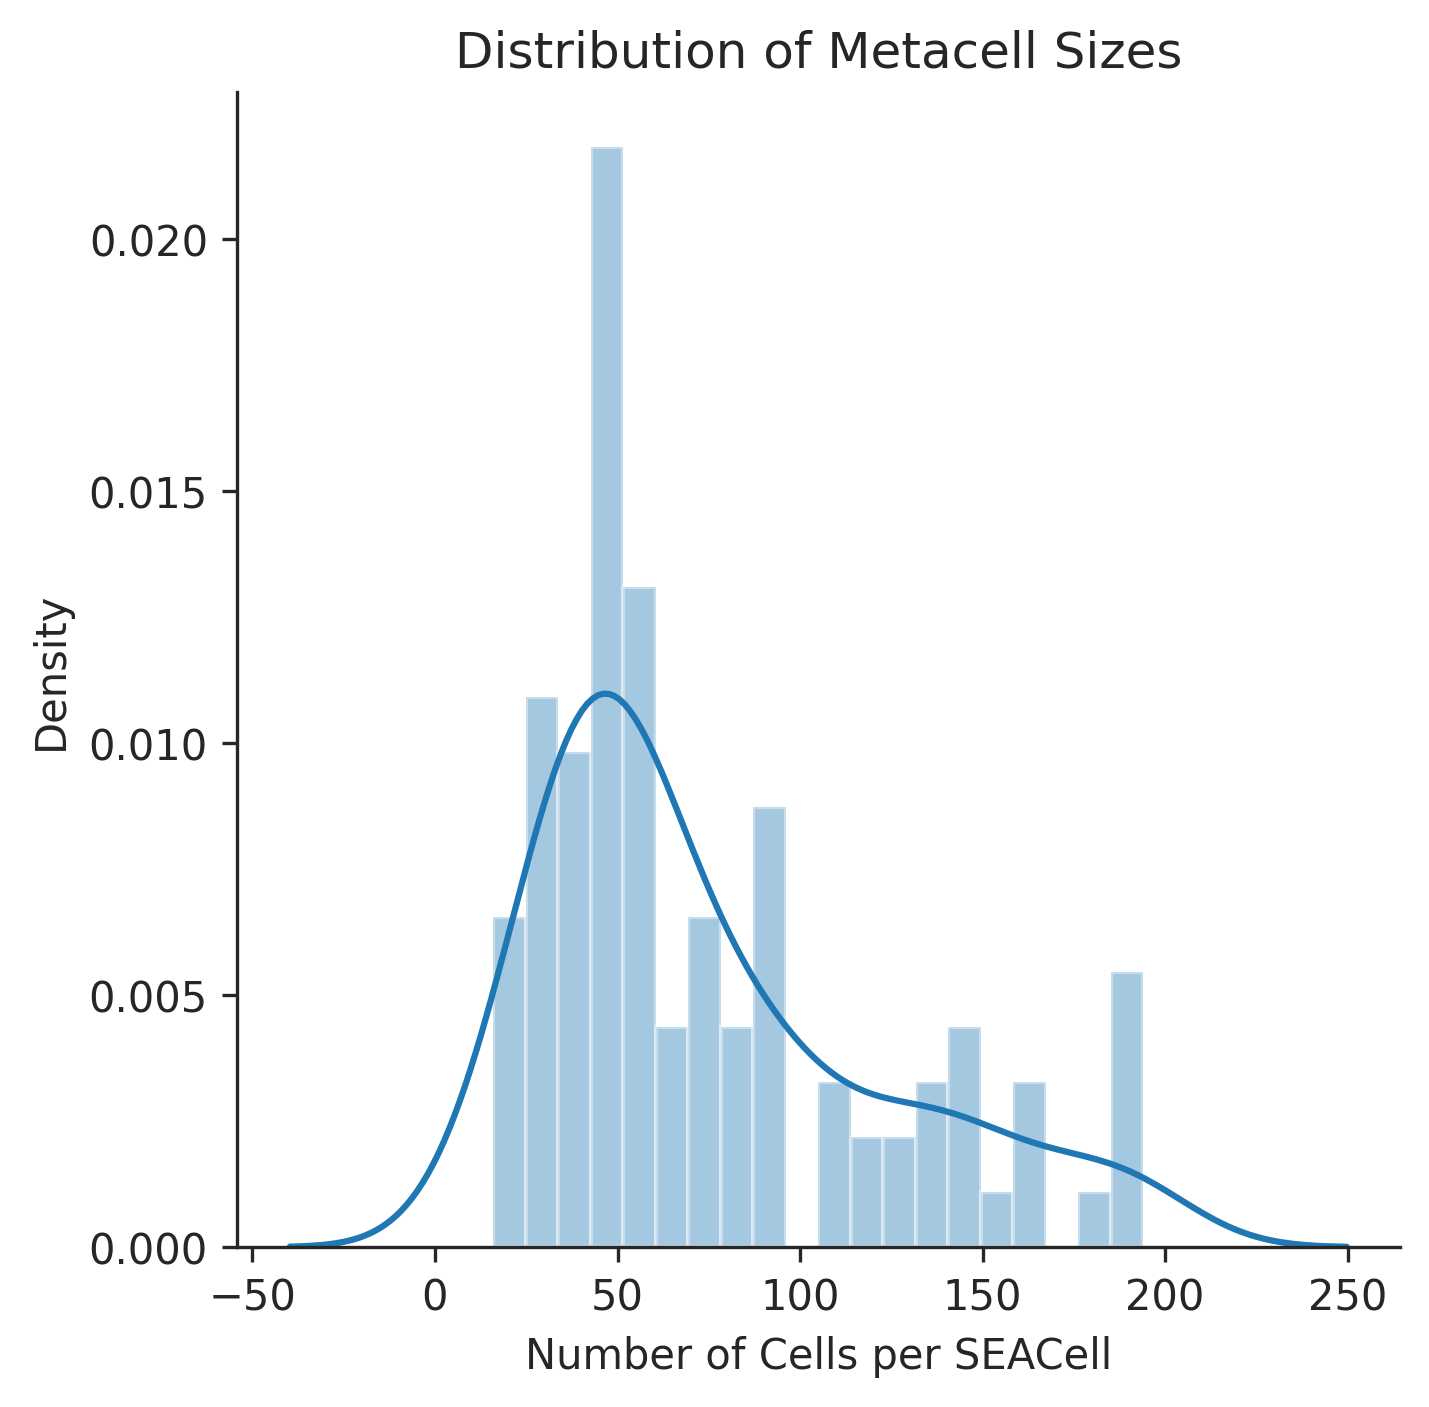

size
SEACell          
SEACell-0      50
SEACell-1      16
SEACell-10     49
SEACell-100   127
SEACell-101    78
...           ...
SEACell-95    129
SEACell-96    133
SEACell-97     52
SEACell-98     44
SEACell-99     29

[103 rows x 1 columns]

In [16]:
#------Plotting SEACell size distribution-----#
SEACells.plot.plot_SEACell_sizes(Matrix, bins=20)

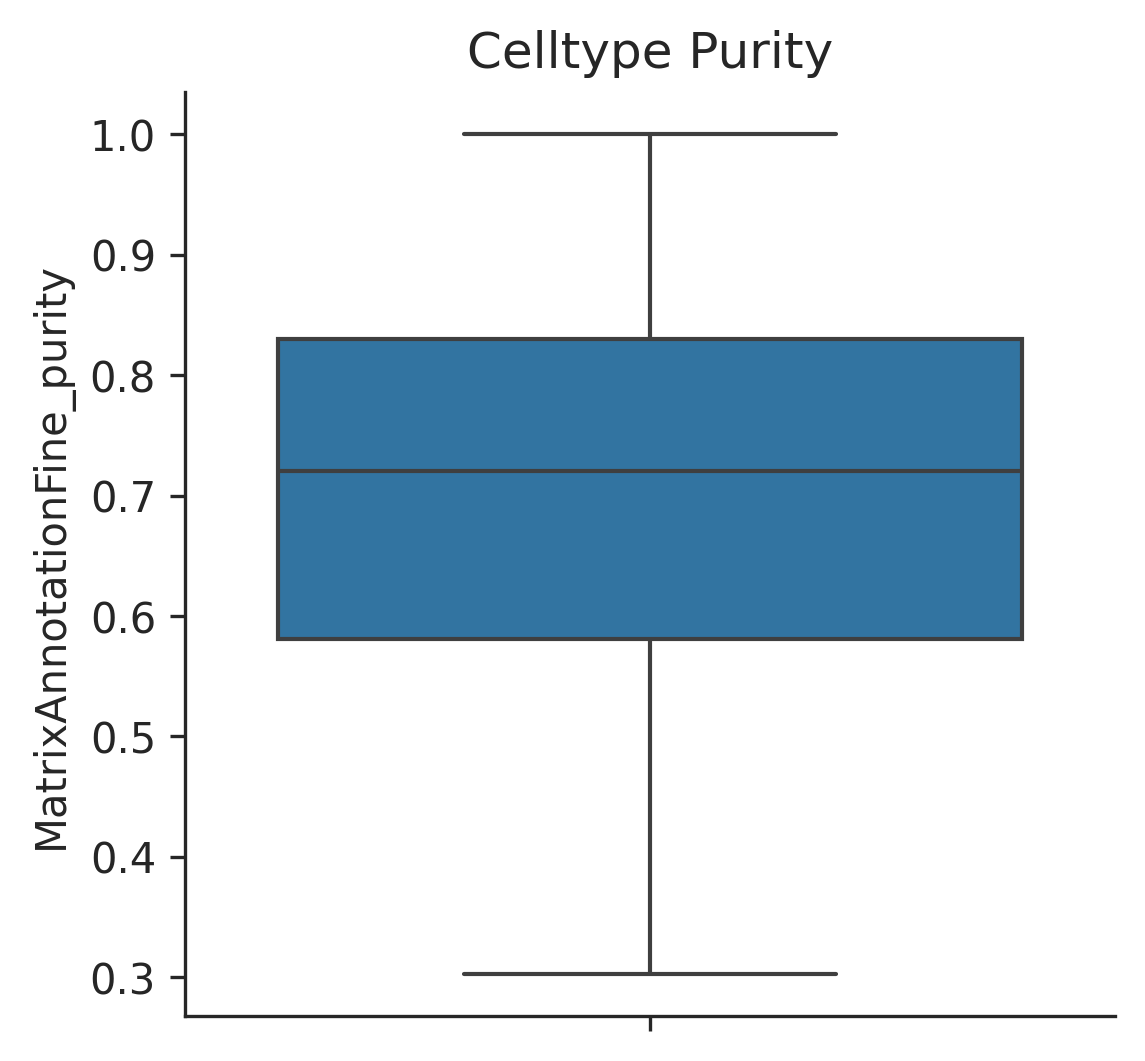

MatrixAnnotationFine  MatrixAnnotationFine_purity
SEACell                                                      
SEACell-0            IRS_Cuticle                     0.760000
SEACell-1                    LPC                     1.000000
SEACell-10           IRS_Cuticle                     0.795918
SEACell-100        Middle_Cortex                     0.677165
SEACell-101         Early_Cortex                     0.871795

In [18]:
#------Computing Celltype Purity------#
SEACell_purity = SEACells.evaluate.compute_celltype_purity(Matrix, 'MatrixAnnotationFine')
#Plotting boxplot
plt.figure(figsize=(4,4))
sns.boxplot(data=SEACell_purity, y='MatrixAnnotationFine_purity')
plt.title('Celltype Purity')
sns.despine()
plt.show()
plt.close()
SEACell_purity.head()

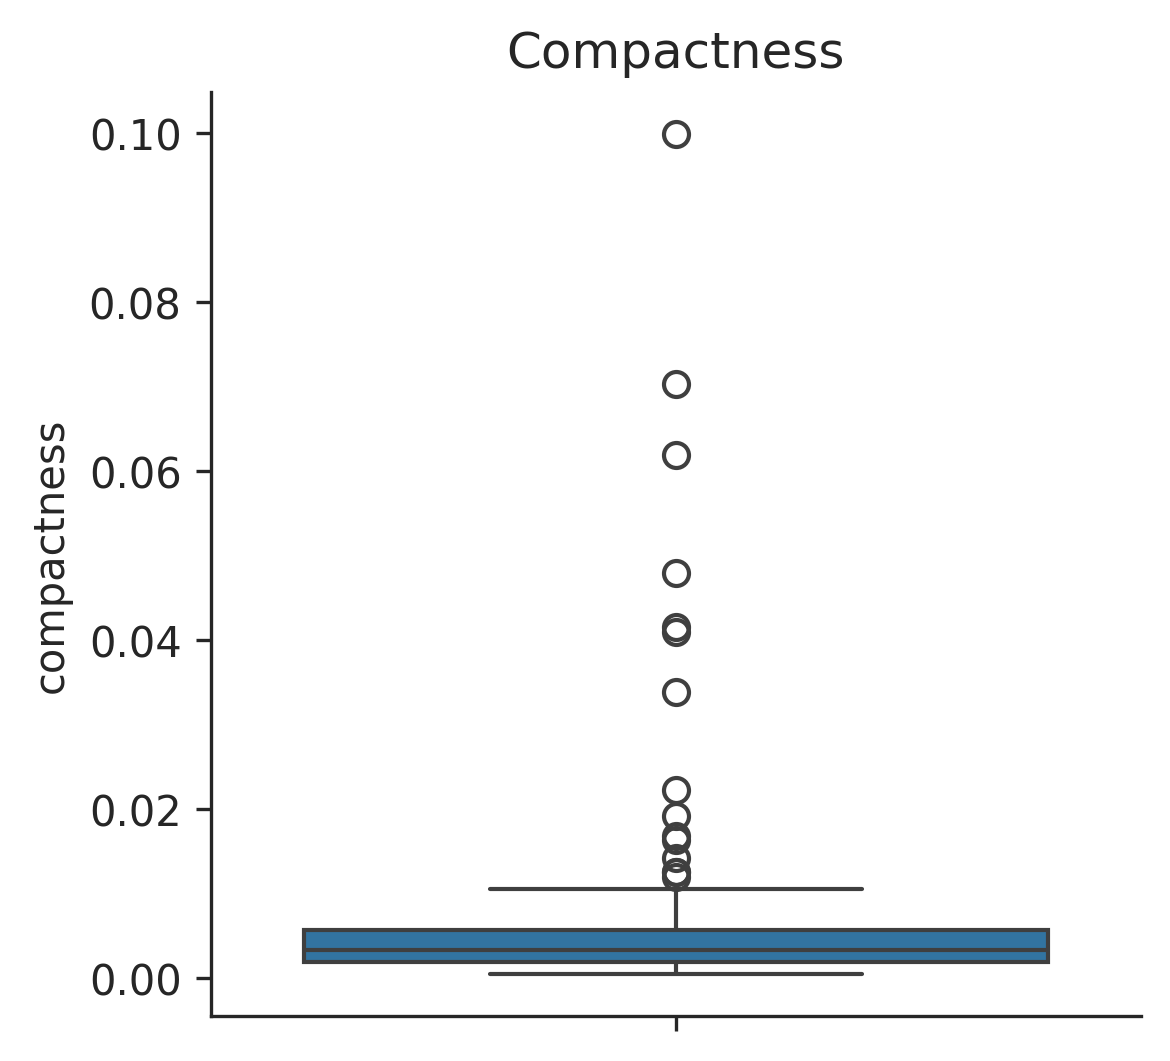

compactness
SEACell                 
SEACell-0       0.002471
SEACell-1       0.000985
SEACell-10      0.001569
SEACell-100     0.001834
SEACell-101     0.001086

In [19]:
#-----Computing Metacell Compactness-----#
compactness = SEACells.evaluate.compactness(Matrix, 'X_harmony')
#Plotting boxplot
plt.figure(figsize=(4,4))
sns.boxplot(data=compactness, y='compactness')
plt.title('Compactness')
sns.despine()
plt.show()
plt.close()
compactness.head()

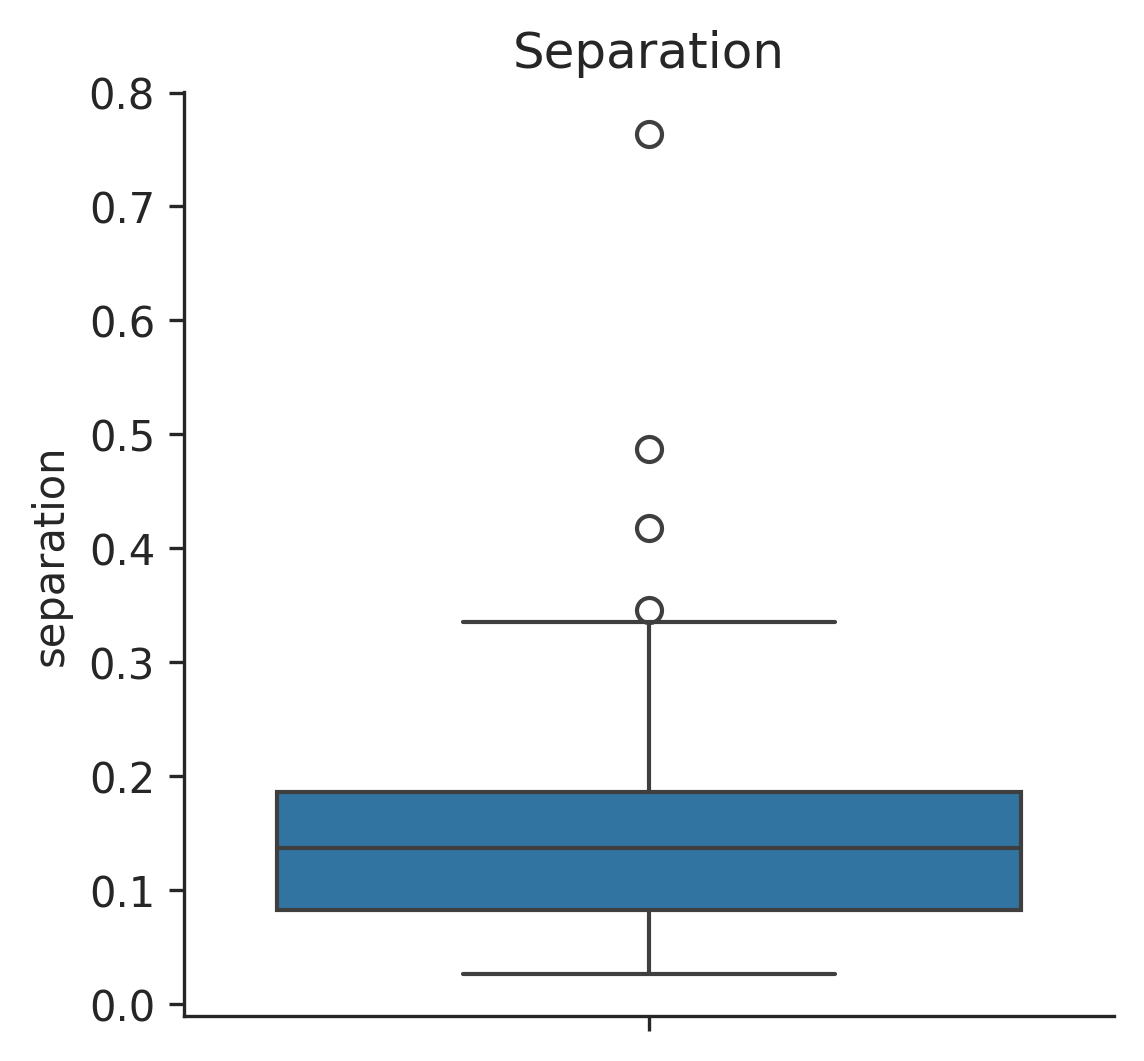

separation
SEACell                
SEACell-0      0.153152
SEACell-1      0.214235
SEACell-10     0.097397
SEACell-100    0.032456
SEACell-101    0.066573

In [20]:
#------Plotting Metacell Separation--------#
separation = SEACells.evaluate.separation(Matrix, 'X_harmony',nth_nbr=1)
#Plotting boxplot
plt.figure(figsize=(4,4))
sns.boxplot(data=separation, y='separation')
plt.title('Separation')
sns.despine()
plt.show()
plt.close()
separation.head()

/projects/b1217/Chris/condaenvs/SEACellsEnv/lib/python3.8/site-packages/seaborn/relational.py:438: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)
/projects/b1217/Chris/condaenvs/SEACellsEnv/lib/python3.8/site-packages/seaborn/relational.py:438: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)


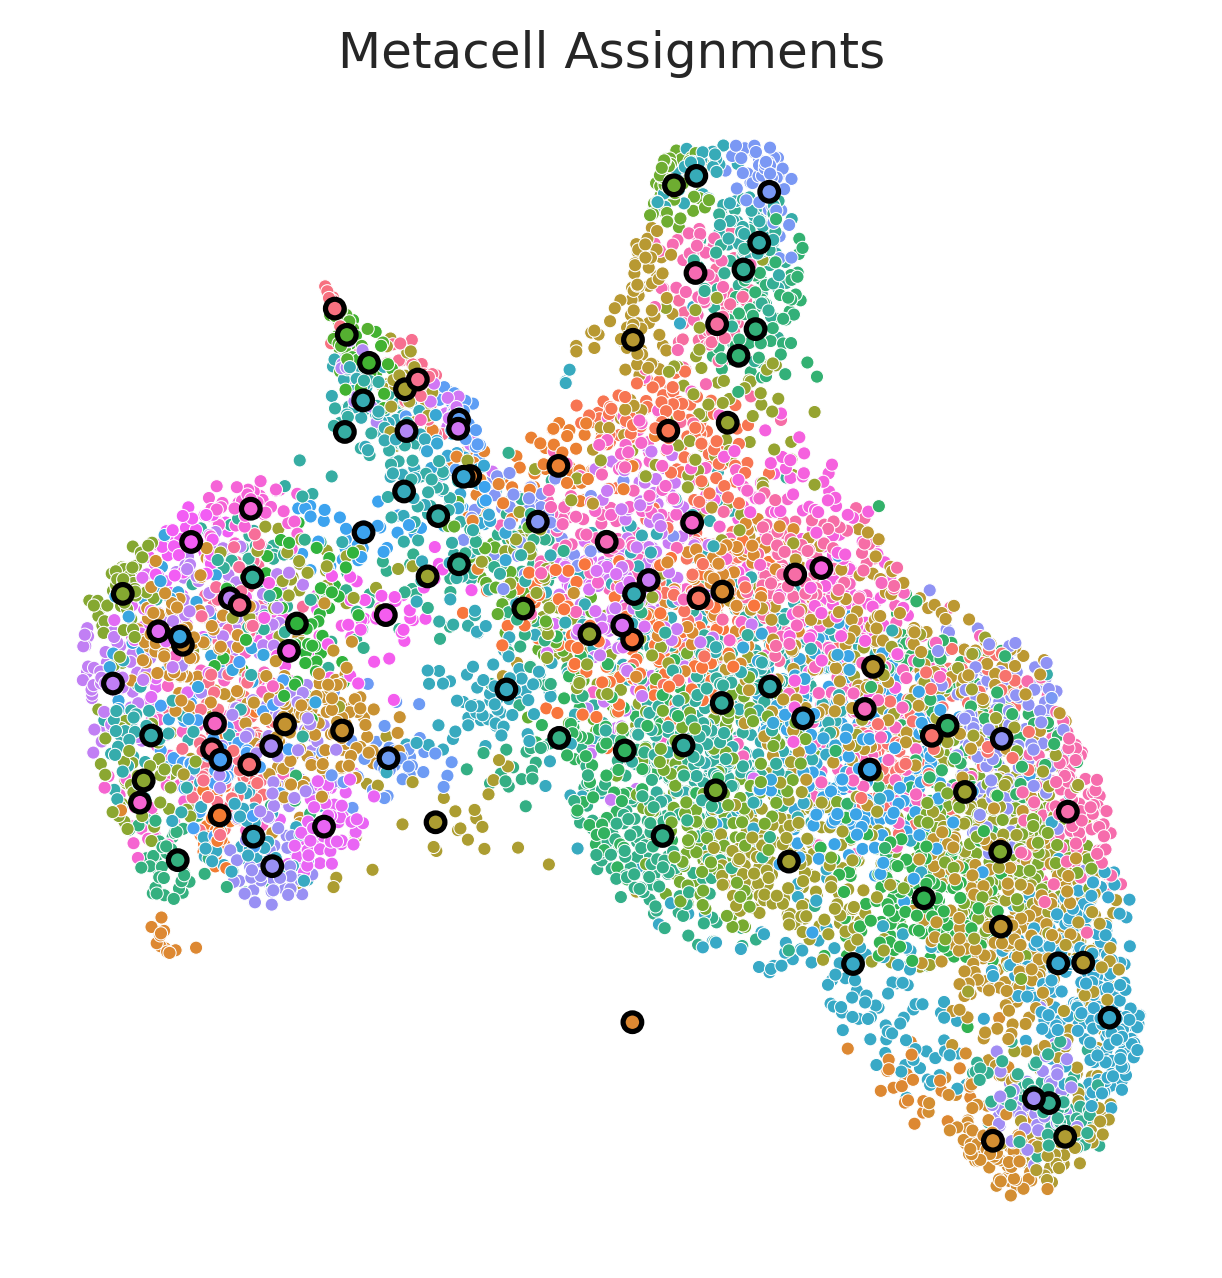

/projects/b1217/Chris/condaenvs/SEACellsEnv/lib/python3.8/site-packages/seaborn/relational.py:438: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)
/projects/b1217/Chris/condaenvs/SEACellsEnv/lib/python3.8/site-packages/seaborn/relational.py:438: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)


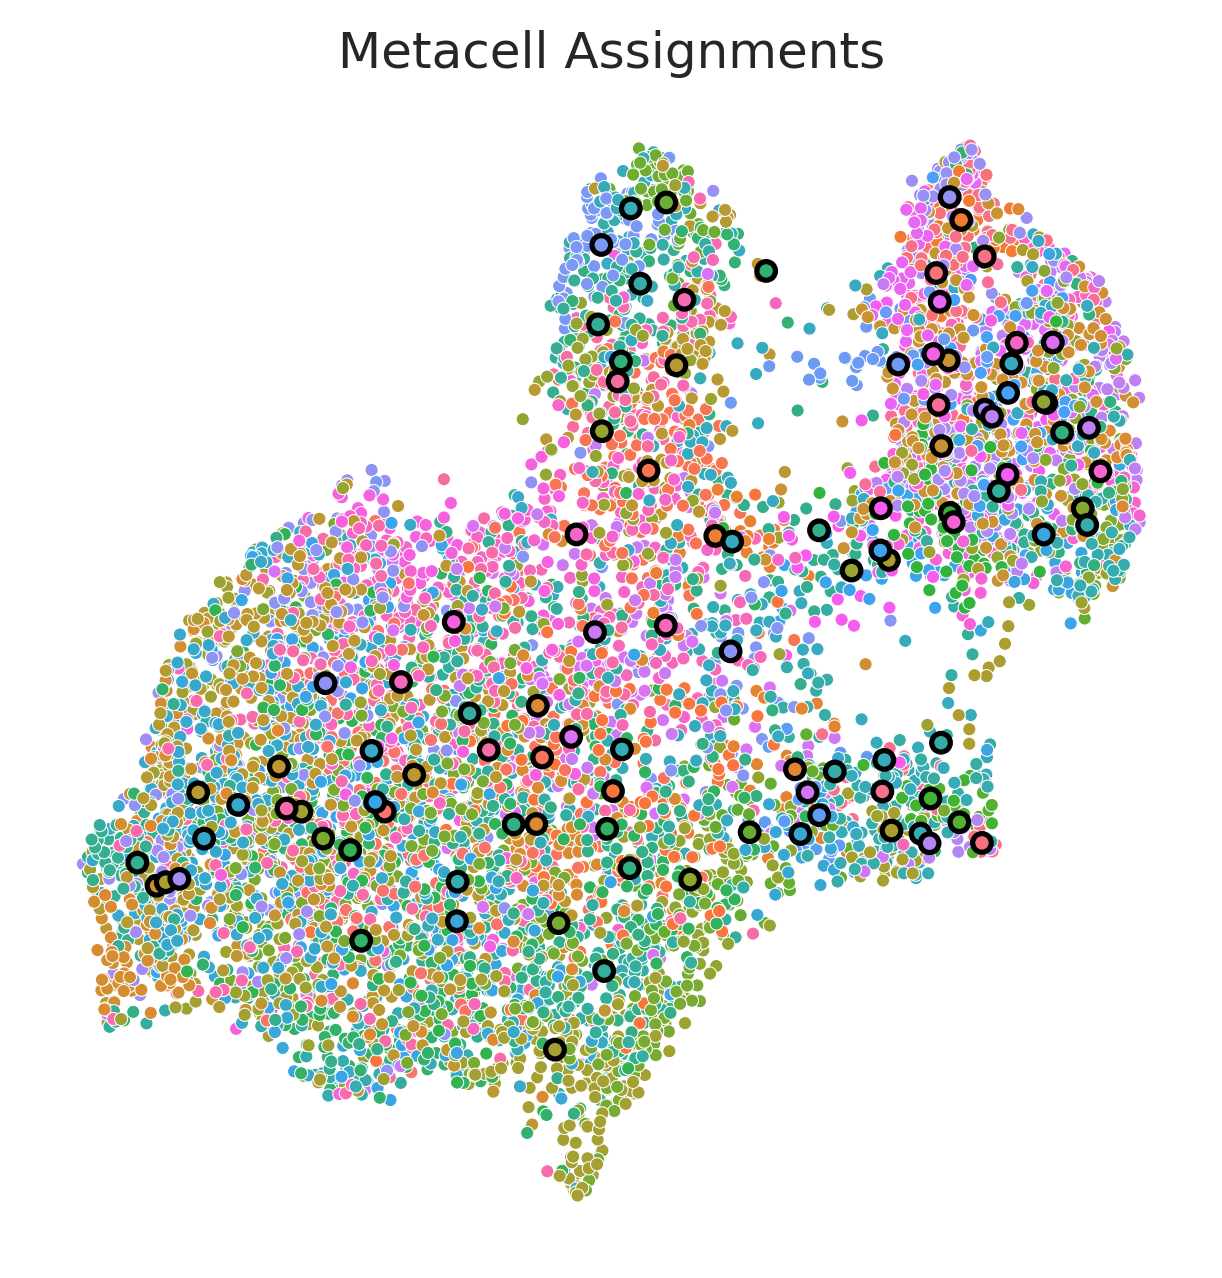

In [21]:
#------Plotting SEACells on UMAPs------#
#ATAC
SEACells.plot.plot_2D(Matrix, key='X_umap_atac', colour_metacells=True)
#WNN
SEACells.plot.plot_2D(Matrix, key='X_umap_wnn', colour_metacells=True)

In [24]:
#--------Aggregating Data into Metacells------#
SEACell_ad = SEACells.core.summarize_by_SEACell(Matrix, SEACells_label='SEACell', summarize_layer='raw')
SEACell_ad

100%|██████████| 103/103 [00:11<00:00,  9.19it/s]


AnnData object with n_obs × n_vars = 103 × 503457
    layers: 'raw'

In [25]:
#---------Saving Results-----#
#writing full object to disk
Matrix.write_h5ad(os.path.join(ConversionDirectory, "HHA_Matrix_Multiome_ATAC_SEACell_5_30_25.h5ad"))
#writing SEACells object to disk
Matrix.write_h5ad(os.path.join(ConversionDirectory, "HHA_Matrix_Multiome_ATAC_SEACells_5_30_25.h5ad"))